CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [5]:
# use/update following 4 lines if used in google-drive 
#from google.colab import drive
#drive.mount('/content/drive')
#import sys
#sys.path.append("/content/drive/MyDrive/Colab Notebooks/w5_assignment_ERA/")

from model import Net
from utils import train, test, train_transforms, test_transforms

Mounted at /content/drive


CODE BLOCK: 2

In [6]:
# check if CUDA is available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [7]:
# load data sets for training and testing 
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms) # flag

100%|██████████| 9912422/9912422 [00:00<00:00, 152070839.27it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33998230.09it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26729632.24it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23063594.15it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 4

In [8]:
# batch size is the number of samples processed before the model is updated
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 5

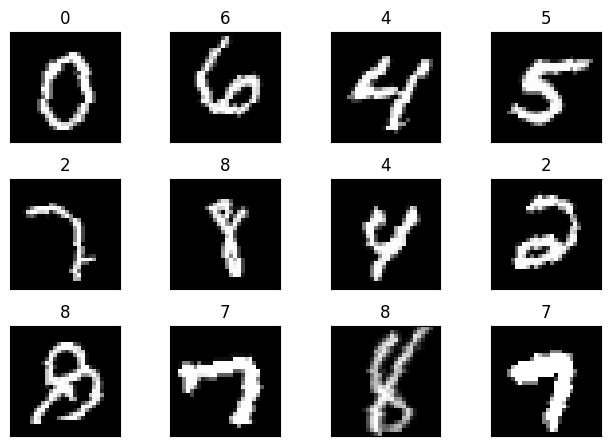

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 6

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 7

In [11]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 8

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.1336 Batch_id=117 Accuracy=20.08: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


Test set: Average loss: 0.0042, Accuracy: 2796/10000 (27.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2648 Batch_id=117 Accuracy=59.38: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


Test set: Average loss: 0.0004, Accuracy: 9413/10000 (94.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1360 Batch_id=117 Accuracy=93.66: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0002, Accuracy: 9669/10000 (96.69%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1104 Batch_id=117 Accuracy=95.80: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s]


Test set: Average loss: 0.0001, Accuracy: 9781/10000 (97.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1105 Batch_id=117 Accuracy=96.59: 100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


Test set: Average loss: 0.0001, Accuracy: 9798/10000 (97.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1299 Batch_id=117 Accuracy=97.04: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s]


Test set: Average loss: 0.0001, Accuracy: 9846/10000 (98.46%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0992 Batch_id=117 Accuracy=97.28: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


Test set: Average loss: 0.0001, Accuracy: 9865/10000 (98.65%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1421 Batch_id=117 Accuracy=97.74: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0493 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0001, Accuracy: 9873/10000 (98.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0802 Batch_id=117 Accuracy=98.02: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


Test set: Average loss: 0.0001, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0422 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]


Test set: Average loss: 0.0001, Accuracy: 9876/10000 (98.76%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0475 Batch_id=117 Accuracy=98.25: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Test set: Average loss: 0.0001, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0220 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


Test set: Average loss: 0.0001, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0714 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Test set: Average loss: 0.0001, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0917 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0000, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0072 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0000, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0225 Batch_id=117 Accuracy=98.88: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0000, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0378 Batch_id=117 Accuracy=98.88: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0000, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0571 Batch_id=117 Accuracy=98.93: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


Test set: Average loss: 0.0000, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0249 Batch_id=117 Accuracy=98.92: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


Test set: Average loss: 0.0000, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 9

Text(0.5, 1.0, 'Test Accuracy')

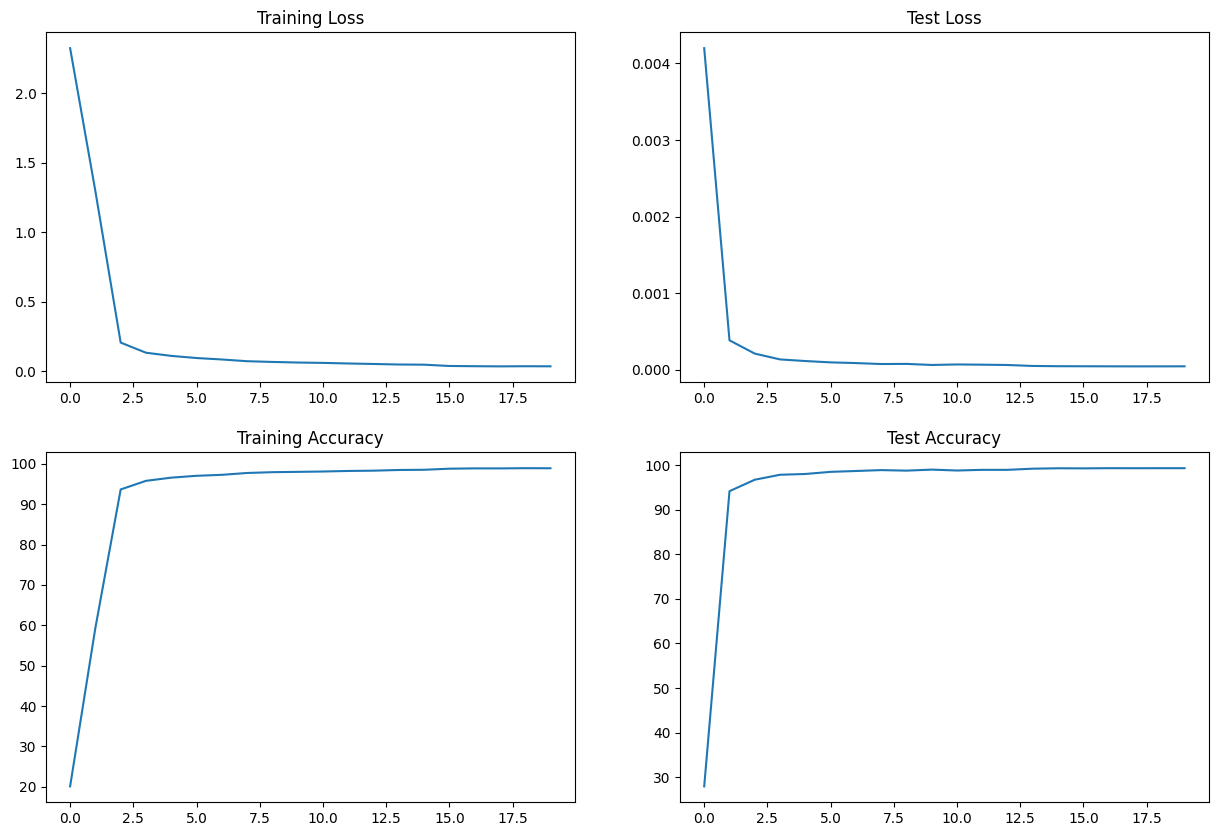

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")